# Q-learning

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from time import time

In [2]:
seeds = [
    960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534, 1822174485, 1871883252, 694388766,
    188312339, 773370613, 2125204119, 2041095833, 1384311643, 1000004583, 358485174, 1695858027, 762772169,
    437720306, 939612284
]

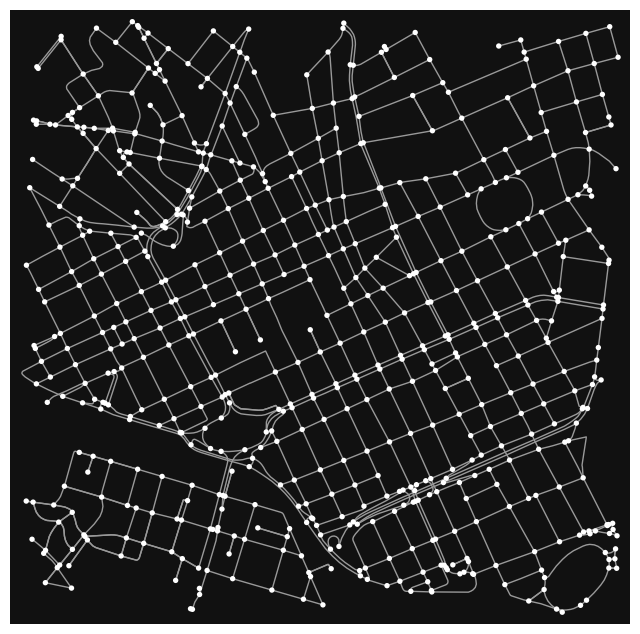

In [3]:
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
ox.plot_graph(G)
source = 507
target = 235

## Helper Functions

In [3]:
class Environment:
    """
    Simulation of graph route that can be deterministic and stochastic.
    The main functionalities is to reset the simulation and returns the state based in the action.
    """

    def __init__(self, G, source, target, reward="weighted", mode="deterministic"):
        self.G = G
        self.max_weight = max([G[u][v][0]["length"] for u, v, m in G.edges if m == 0])
        self.source = source
        self.target = target
        self.reward = reward

        assert mode in [
            "deterministic",
            "stochastic",
        ], "Mode must be deterministic or stochastic"
        if mode == "deterministic":
            self.step = self.step_deterministic
        elif mode == "stochastic":
            self.step = self.step_stochastic

    def get_n_states(self):
        """Get number of states"""
        return len(self.G.nodes)

    def reset(self):
        """Return to the source state that is not the destination"""
        self.state = self.source
        return self.state

    def step_deterministic(self, action):
        """Return new state, reward, and if simulation is done"""

        # if is not the target, and the action is to stay in the same node
        if (action == self.state) & (action != self.target):
            return self.state, -1, False

        # if reached the target
        if self.state == self.target:
            return self.state, 10000, True

        # weight of the edge
        w = self.G[self.state][action][0]["length"] / self.max_weight
        # now, the state is the next node
        self.state = action

        # if the action leaves to a dead end
        neighbors = list(self.G.neighbors(self.state))
        if len(neighbors) == 0:
            return self.state, -1000, True

        if self.reward == "unit":
            return self.state, 0, False
        elif self.reward == "weighted":
            return self.state, -w, False
            

    def step_stochastic(self, action):
        """Return new state, reward, and if the destination is reached"""
        if np.random.rand() < 0.05:  # 5% probability of not moving
            return self.state, 0, False

        # if is not the target, and the action is to stay in the same node
        if (action == self.state) & (action != self.target):
            return self.state, -1, False

        # if reached the target
        if self.state == self.target:
            return self.state, 10000, True

        # weight of the edge
        w = self.G[self.state][action][0]["length"] / self.max_weight
        self.state = action

        # if the action leaves to a dead end
        neighbors = list(self.G.neighbors(self.state))
        if len(neighbors) == 0:
            return self.state, -1000, True

        if self.reward == "unit":
            return self.state, 0, False
        elif self.reward == "weighted":
            w_ = w + np.random.normal(scale=0.1)
            return self.state, -w_, False

### Plotting

In [4]:

def plot_graph(G, source = None, target = None):
    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
    )

    try:
        for u, v, m in G.edges:
            if m == 0:
                plt.plot(
                    [G.nodes[u]["x"], G.nodes[v]["x"]],
                    [G.nodes[u]["y"], G.nodes[v]["y"]],
                    color="black",
                    alpha=0.25,
                )
    except:
        for u, v in G.edges:
            plt.plot(
                [G.nodes[u]["x"], G.nodes[v]["x"]],
                [G.nodes[u]["y"], G.nodes[v]["y"]],
                color="black",
                alpha=0.25,
            )

    if source is not None and target is not None:
        plt.scatter(
            [G.nodes[source]["x"], G.nodes[target]["x"]],
            [G.nodes[source]["y"], G.nodes[target]["y"]],
            color=["green", "red"],
            alpha=1,
            s=100,
        )

        red_patch = mpatches.Patch(color="red", label="Target")
        green_patch = mpatches.Patch(color="green", label="Source")
        plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])

        

def plot_all_paths_policy(G, policy, source, target):

    plot_graph(G, source, target)

    for i in G.nodes:
        dest = policy[i]

        # verify if there is a edge between i and dest, if not, continue
        if (i, dest) not in G.edges:
            continue

        plt.arrow(
            G.nodes[i]["x"],
            G.nodes[i]["y"],
            (G.nodes[dest]["x"] - G.nodes[i]["x"]) * 0.7,
            (G.nodes[dest]["y"] - G.nodes[i]["y"]) * 0.7,
            alpha=0.8,
            width=0.0001,
        )



def plot_few_steps_policy(G, policy, source, target, steps=5):
    plot_graph(G, source, target)


    state = source
    for i in range(steps):
        dest = policy[state]

        # verify if there is a edge between i and dest, if not, continue
        if (state, dest) not in G.edges:
            continue

        plt.arrow(
            G.nodes[state]["x"],
            G.nodes[state]["y"],
            (G.nodes[dest]["x"] - G.nodes[state]["x"]) * 0.95,
            (G.nodes[dest]["y"] - G.nodes[state]["y"]) * 0.95,
            alpha=0.8,
            width=0.0001,
        )
        state = dest


def plot_value_func(G, source, target, value_func):
    plot_graph(G, source, target)
    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        c=value_func,
        cmap="YlOrRd",
    )


## QLearning algorithm

In [5]:
class QLAgent:
    def __init__(
        self, 
        env, 
        learning_rate = 0.7, 
        gamma = 0.99,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
        tol = 1e-6,
        seed = None
    ):
        self.env = env
        self.n_states = env.get_n_states()
        self.set_Q()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.tol = tol
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

    def set_Q(self):
        self.Q = np.zeros((self.n_states, self.n_states))
        for state in range(self.n_states):
            for action in range(self.n_states):
                if state == action:
                    self.Q[state, action] = 0
                else:
                    try:
                        self.env.G[state][action][0]["length"]
                        self.Q[state, action] = 0
                    except:
                        self.Q[state, action] = -np.inf
                
    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        return np.random.choice(np.where(self.Q[state, :] == np.max(self.Q[state, :]))[0])
    
    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state))
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        state = self.env.reset()
        self.episode_rewards.append(0)
        route = [state]

        for step in range(self.max_steps):
            # Choose action and get reward
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward    
            
            # update Q table based on Bellman equation
            self.Q[state, action] += self.learning_rate * (
                reward
                + self.gamma * np.max(self.Q[new_state, :])
                - self.Q[state, action]
            )
            state = new_state
            route.append(state)

            if done:
                break
    
    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
    
    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()
            
        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}
        self.value = np.max(self.Q, axis = 1)
          

    
    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        
        for _ in range(1000):
            new_state = self.policy[state]
            route.append(new_state)
            
            if new_state == state:
                cost = np.inf
                break

            cost += G[state][new_state][0]["length"]

            if new_state == target:
                break

            state = new_state


        if route[-1] != target:
            cost = np.inf
        return route, cost

### Parameters experiments

In [10]:
def experiment_handler(seeds, env, fixed_agent_params, testing_agent_param):
    testing_agent_param_name = testing_agent_param[0]
    testing_agent_param_values = testing_agent_param[1]
    results = []
    env.reset()
    for value in tqdm(testing_agent_param_values):
        fixed_agent_params[testing_agent_param_name] = value
        for i, seed in enumerate(seeds):
            start = time()
            agent = QLAgent(
                env = env,
                seed = seed,
                **fixed_agent_params,
            )
            agent.train()
            end = time()
            route, cost = agent.route_to_target(G, env.source, env.target)
            results.append(
                {"seed" : seed,
                 testing_agent_param_name : value,
                 "cost" : cost,
                 "time" : end - start,
                 "rewards" : agent.episode_rewards,
                }
            )
            env.reset()

    return results

In [6]:
env = Environment(G, source, target, "unit", "deterministic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/unit_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/unit_deterministic_lr.json")
env = Environment(G, source, target, "weighted", "deterministic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/weighted_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/weighted_deterministic_lr.json")

In [28]:
env = Environment(G, source, target, "unit", "stochastic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/unit_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/unit_stochastic_lr.json")
env = Environment(G, source, target, "weighted", "stochastic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/weighted_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/weighted_stochastic_lr.json")

100%|██████████| 5/5 [04:03<00:00, 48.79s/it]


In [11]:

def analysis_results(reward_method, env_method):
    results_lr = pd.read_json(f"results/{reward_method}_{env_method}_lr.json")
    results_gamma = pd.read_json(f"results/{reward_method}_{env_method}_gamma.json")
    results_lr["rewards"] = results_lr.rewards.apply(np.mean)
    results_gamma["rewards"] = results_gamma.rewards.apply(np.mean)

    results_lr = results_lr.groupby("learning_rate").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_lr.columns = ["_".join(col) for col in results_lr.columns]
    results_lr = results_lr.reset_index()

    results_gamma = results_gamma.groupby("gamma").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_gamma.columns = ["_".join(col) for col in results_gamma.columns]
    results_gamma = results_gamma.reset_index()
    better_names = {
        "unit" : "Unit",
        "weighted" : "Weighted",
        "deterministic" : "Deterministic",
        "stochastic" : "Stochastic",
    }
    plot_results_experiments(results_lr, results_gamma, f"Parameter evaluation\n{better_names[reward_method]} reward and {better_names[env_method]} environment")

def plot_results_experiments(results_lr, results_gamma, title):
    """Plot the results of the experiments varying learning rate and gamma.

    Parameters
    ----------
    results_lr : pd.DataFrame
        Dataframe with columns learning_rate, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    results_gamma : pd.DataFrame
        Dataframe with columns gamma, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    title : str 
        Title of the plot
    """
    better_names = {
        "cost" : "Path cost",
        "time" : "Computing time",
        "rewards" : "Rewards",
        "learning_rate" : "Learning rate (α)",
        "gamma" : "Discount factor (γ)",
    }
    def plot_line_plot_err(df, param, cost, ax):
        ax.plot(df[param], df[f"{cost}_mean"], color = "black")
        ax.fill_between(
            df[param],
            df[f"{cost}_mean"] - df[f"{cost}_std"],
            df[f"{cost}_mean"] + df[f"{cost}_std"],
            color = "black",
            alpha = 0.2
        )
        ax.set_xlabel(better_names[param])
        ax.set_ylabel(better_names[cost])
        ax.set_title(f"{better_names[param]} x {better_names[cost]}")
        ax.grid()
        

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 7), sharey="col")
    axs = axs.flatten()

    plot_line_plot_err(results_lr, "learning_rate", "cost", axs[0])
    plot_line_plot_err(results_lr, "learning_rate", "time", axs[1])
    plot_line_plot_err(results_lr, "learning_rate", "rewards", axs[2])

    plot_line_plot_err(results_gamma, "gamma", "cost", axs[3])
    plot_line_plot_err(results_gamma, "gamma", "time", axs[4])
    plot_line_plot_err(results_gamma, "gamma", "rewards", axs[5])

    plt.suptitle(title, fontsize = 14)
    plt.tight_layout()
    plt.show()


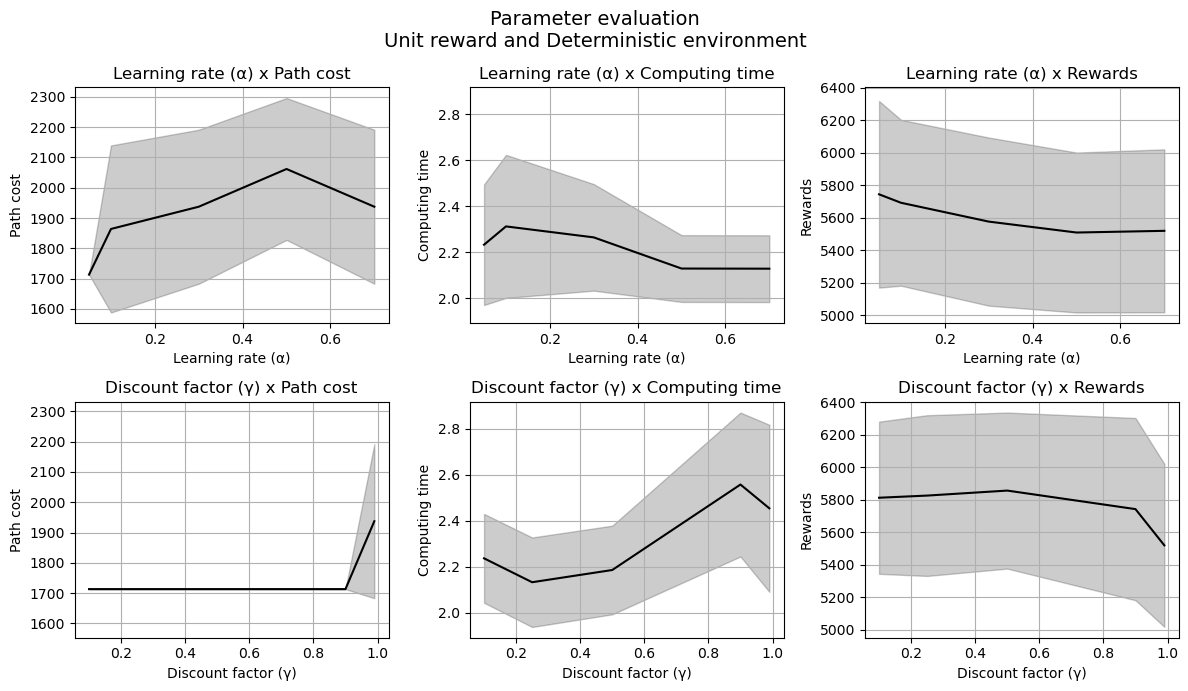

In [30]:
analysis_results("unit", "deterministic")

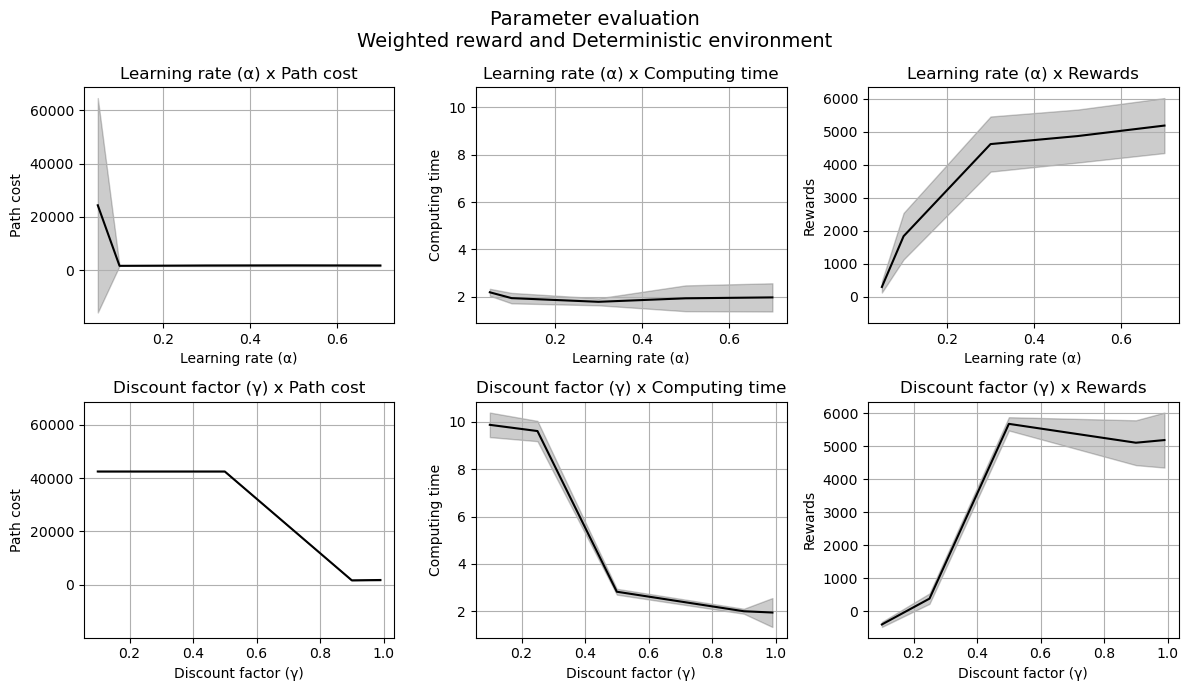

In [31]:
analysis_results("weighted", "deterministic")

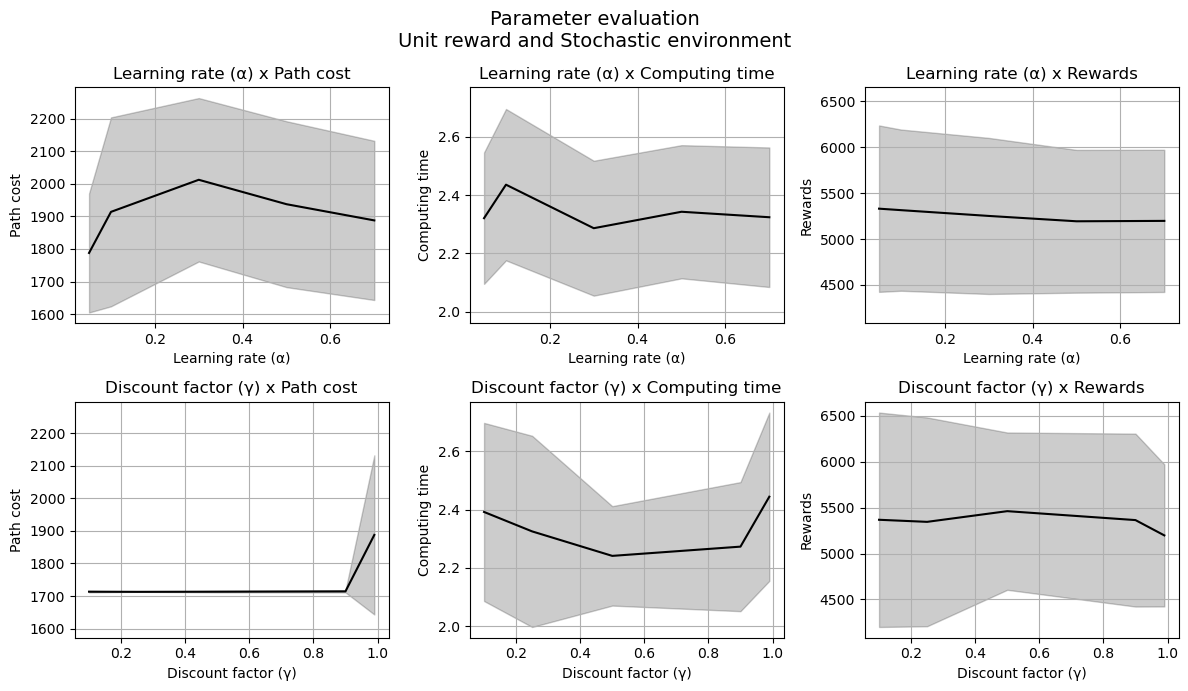

In [32]:
analysis_results("unit", "stochastic")

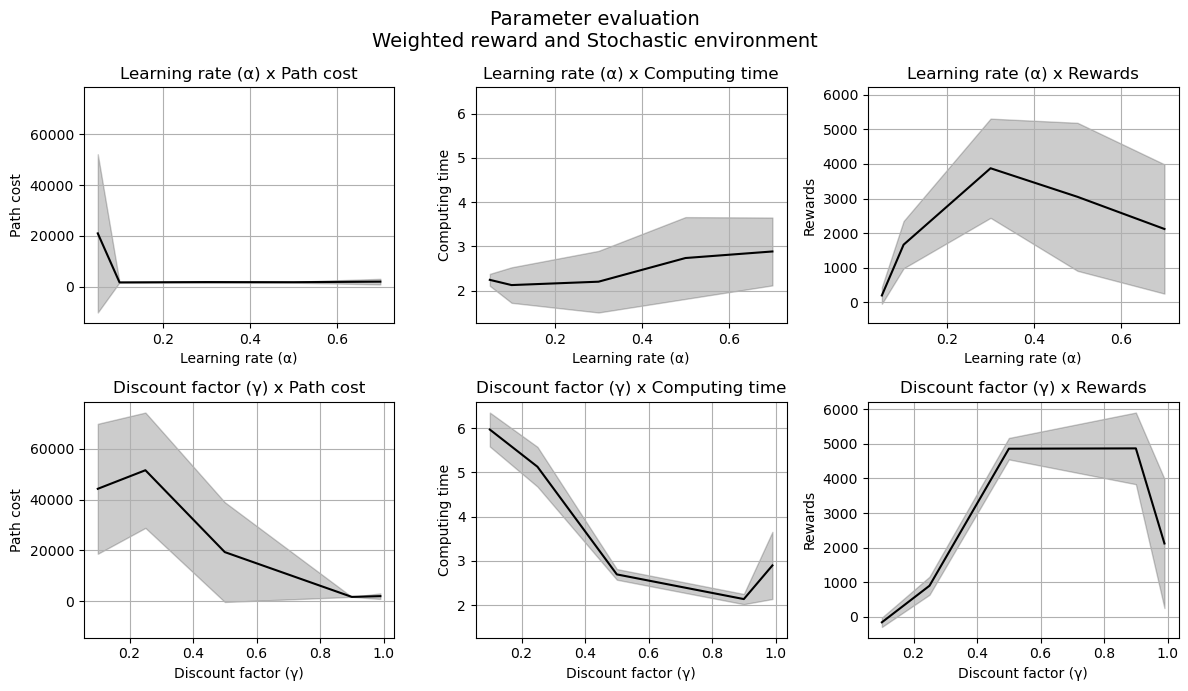

In [33]:
analysis_results("weighted", "stochastic")

### Generalization experiments

In [7]:
env = Environment(G, source, target, reward = "weighted", mode = "deterministic")
n_episodes_list = [1000, 2000, 5000, 10000]
reach_list = []
for n_episodes in n_episodes_list:
    env.reset()
    agent = QLAgent(env, learning_rate=0.3, gamma = 0.9, n_episodes=n_episodes)
    agent.train()


    n_reached = 0
    n_possible = len(G.nodes)
    for i in range(len(G.nodes)):
        try:
            nx.shortest_path_length(G, i, target, weight="length")
            _, cost = agent.route_to_target(G, i, target)

            if cost != np.inf:
                n_reached += 1
        except:
            n_possible -= 1
    
    reach_list.append(n_reached / n_possible)

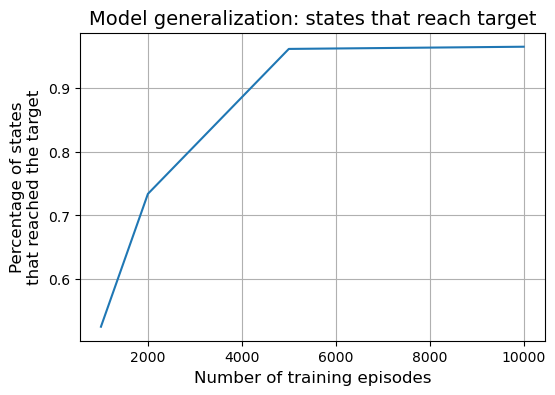

In [53]:
fig = plt.figure(figsize=(6, 4))
plt.plot(n_episodes_list, reach_list)
plt.xlabel("Number of training episodes", fontsize = 12)
plt.ylabel("Percentage of states\nthat reached the target", fontsize = 12)
plt.title("Model generalization: states that reach target", fontsize = 14)
plt.grid()
plt.ylim(0.4, 1)
plt.show()

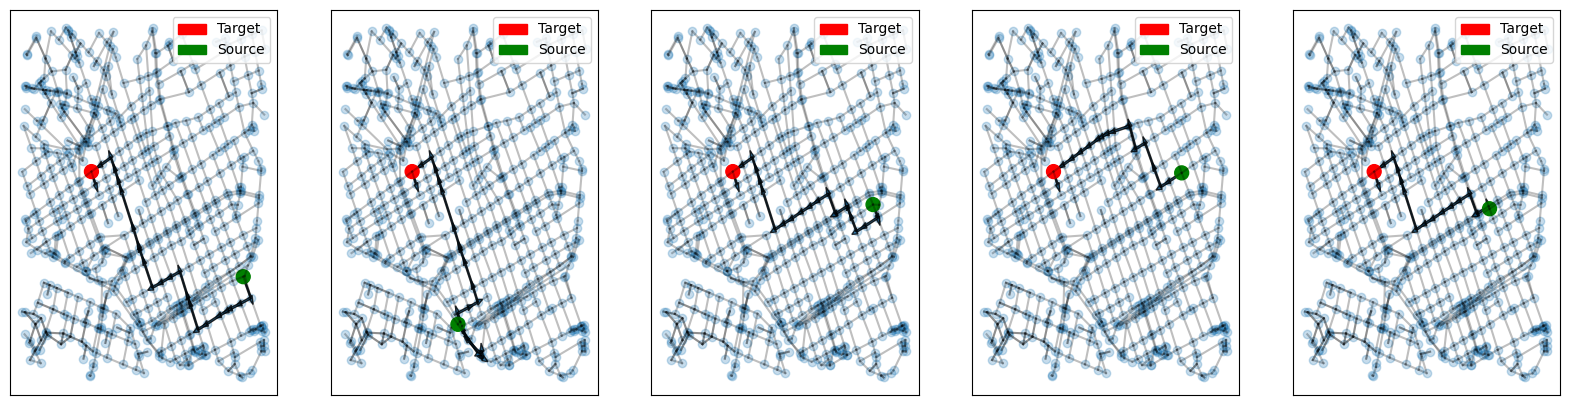

In [40]:
random_states = []

while len(random_states) < 5:
    state = np.random.choice(list(G.nodes))
    if state not in random_states and nx.has_path(G, state, target):
        random_states.append(state)

#fig, axs = plt.subplots(nrows = 1, ncols = 5)

fig = plt.figure(figsize=(20, 5))

for i, state in enumerate(random_states):
    route, cost = agent.route_to_target(G, state, target)

    steps = min(30, len(route))
    plt.subplot(1, 5, i + 1)
    plot_few_steps_policy(G, agent.policy, state, target, steps=steps)

In [12]:
def experiment_handler2(seeds, env, agent_params = {}):
    results = []
    env.reset()
    for i, seed in tqdm(enumerate(seeds)):
        np.random.seed(seed)
        source, target = np.random.choice(env.get_n_states(), size = 2)
        while not nx.has_path(G, source, target):
            source, target = np.random.choice(env.get_n_states(), size = 2)
        
        env.source = source
        env.target = target
        env.reset()

        start = time()
        agent = QLAgent(env = env, seed = seed, **agent_params)  
        agent.train()
        end = time()
        route, cost = agent.route_to_target(G, env.source, env.target)
        optim_cost = nx.shortest_path_length(G, source, target, weight="length")
        
        results.append({
            "seed" : seed,
            "source" : source,
            "target" : target,
            "cost" : cost / optim_cost,    
            "time" : end - start,
            "rewards" : agent.episode_rewards,
        })
    return results

In [ ]:
agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
    "learning_rate" : 0.5,
    "gamma" : 0.95,
}
for scheme in ["unit", "weighted"]:
    for simul in ["deterministic", "stochastic"]:
        env = Environment(G, 0, 1, scheme, simul)
        results_general = experiment_handler2(
            seeds,
            env,
            agent_params,
        )
        pd.DataFrame(results_general).to_json(f"results/{scheme}_{simul}_general.json")

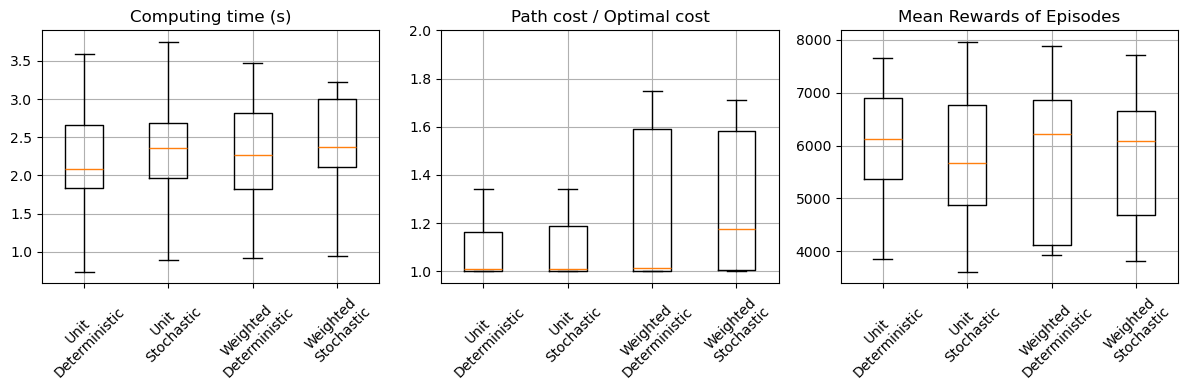

In [19]:
better_names = {
    "time" : "Computing time (s)",
    "cost" : "Path cost / Optimal cost",
    "rewards" : "Mean Rewards of Episodes",
}
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
for i, metric in enumerate(["time", "cost", "rewards"]):
    results_to_plot = []
    for scheme in ["unit", "weighted"]:
        for simul in ["deterministic", "stochastic"]:
            result = pd.read_json(f"results/{scheme}_{simul}_general.json")
            result["rewards"] = result["rewards"].apply(np.mean)
            results_to_plot.append(result[metric])
    axs[i].boxplot(results_to_plot, sym = "")
    if i == 1:
        axs[i].set_ylim(0.95, 2)

    axs[i].set_xticklabels(["Unit\nDeterministic", "Unit\nStochastic", "Weighted\nDeterministic", "Weighted\nStochastic"], rotation = 45)
    axs[i].set_title(better_names[metric])

    axs[i].grid()
plt.tight_layout()
plt.show()

### Value function

In [8]:
env = Environment(G, source, target, reward = "unit", mode = "stochastic")
agent1 = QLAgent(env, learning_rate=0.3, gamma = 0.9)
agent1.train()

env = Environment(G, source, target, reward = "weighted", mode = "stochastic")
agent2 = QLAgent(env, learning_rate=0.3, gamma = 0.9)
agent2.train()

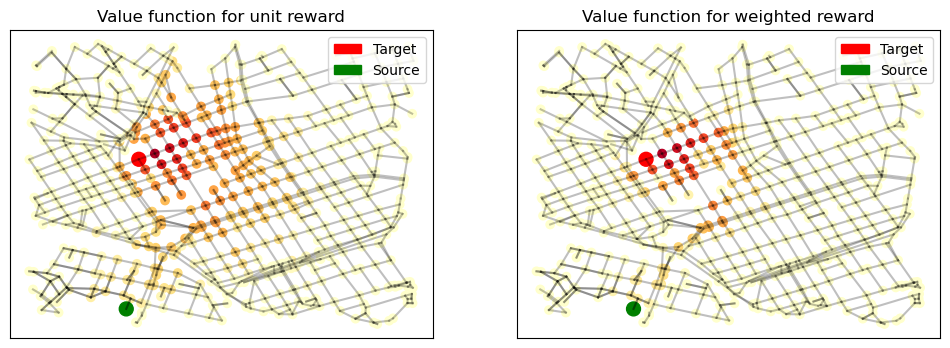

In [41]:
fig = plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
value1 = agent1.Q.max(axis = 1)
plot_value_func(G, source, target, value1)
plt.title("Value function for unit reward")

plt.subplot(1, 2, 2)
value2 = agent2.Q.max(axis = 1)
plot_value_func(G, source, target, value2)
plt.title("Value function for weighted reward")
plt.show()

## QLearning algorithm with linear approximation

In [13]:
class QLAgent_approx:
    def __init__(
        self, 
        env,
        G,
        learning_rate = 0.5, 
        gamma = 0.95,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
        feature_type = "position",
        seed = None
    ):
        self.env = env
        self.G = G
        self.n_states = env.get_n_states()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.feature_type = feature_type
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

        self.features = np.zeros((self.n_states, 3))
        for state in range(self.n_states):
            self.features[state, 0] = self.G.nodes[state]["x"]
            self.features[state, 1] = self.G.nodes[state]["y"]
            self.features[state, 2] = len(self.G[state])
        self.features[:, 0] = self.features[:, 0] / np.max(self.features[:, 0])
        self.features[:, 1] = self.features[:, 1] / np.max(self.features[:, 1])
        self.features[:, 2] = self.features[:, 2] / np.max(self.features[:, 2])
        
        self.input_dim = self.get_feature(0, 0).shape[0]
        self.weights = np.zeros(shape = self.input_dim)
        self.weights_history = []

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def get_feature(self, state, action):
        if self.feature_type == "position":
            features = np.concatenate((self.features[state], self.features[action], [1]))
        elif self.feature_type == "one_hot":
            features = np.zeros(self.n_states * 2 + 7)
            features[state] = 1
            features[self.n_states + action] = 1
            features[-7:-4] = self.features[state]
            features[-4:-1] = self.features[action]
            features[-1] = 1
        return features

    def linear_func(self, state, action, return_feature = False):
        """For each pair of state and action, compute 6 features: 
        (x, y) coordinates of the state/action, and the number of neighbors of each one.
        Then, compute the linear combination of the features with the weights and bias.

        Parameters
        ----------
        state : int
            Index of the state
        action : int
            Index of the action

        Returns
        -------
        float
            Q value of the pair (state, action)
        """
        features = self.get_feature(state, action)
        prediction = np.dot(self.weights, features)
        if return_feature:
            return prediction, features
        return prediction
    
    def update_weights(self, reward, state, action, new_state):
        """Update the weights and bias based on the Bellman equation"""
        target = reward + self.gamma * self.argmax(new_state)
        prediction, features = self.linear_func(state, action, True)
        error = target - prediction
        for i in range(len(self.weights)):
            self.weights[i] += self.learning_rate * error * features[i]

    def argmax(self, state):
        neighbors = list(self.G.neighbors(state))
        if len(neighbors) == 0:
            neighbors = [state]
        return np.max([self.linear_func(state, action) for action in neighbors])
    
    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        neighbors = list(self.G.neighbors(state))
        if len(neighbors) == 0:
            neighbors = [state]
        return neighbors[np.argmax([self.linear_func(state, action) for action in neighbors])]
    
    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.G.neighbors(state))
            if len(neighbors) == 0:
                neighbors = [state]
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        state = self.env.reset()
        self.episode_rewards.append(0)
        route = [state]

        for step in range(self.max_steps):
            # Choose action and get reward
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward    
            
            self.update_weights(reward, state, action, new_state)
            
            state = new_state
            route.append(state)

            if done:
                break
    
    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
    
    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()

            if episode % 100 == 0:
                self.weights_history.append(self.weights.copy())
            
        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}
          

    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            if new_state == state:
                cost = np.inf
                route.append(new_state)
                break
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost

### Parameter Experiments

In [14]:
def experiment_handler3(seeds, env, fixed_agent_params, testing_agent_param):
    testing_agent_param_name = testing_agent_param[0]
    testing_agent_param_values = testing_agent_param[1]
    results = []
    env.reset()
    for value in tqdm(testing_agent_param_values):
        fixed_agent_params[testing_agent_param_name] = value
        for i, seed in enumerate(seeds):
            start = time()
            agent = QLAgent_approx(
                env = env,
                G = env.G,
                seed = seed,
                **fixed_agent_params,
            )
            agent.train()
            end = time()
            _, cost = agent.route_to_target(G, env.source, env.target)
            results.append(
                {"seed" : seed,
                 testing_agent_param_name : value,
                 "cost" : cost,
                 "time" : end - start,
                 "rewards" : agent.episode_rewards,
                }
            )
            env.reset()

    return results

In [37]:
def analysis_results3(reward_method, env_method):
    results_lr = pd.read_json(f"results/func_{reward_method}_{env_method}_lr.json")
    results_lr["rewards"] = results_lr.rewards.apply(np.mean)
    results_lr_agg = []
    lr_values = results_lr.learning_rate.unique()
    for lr in lr_values:
        results_lr_filter = results_lr[results_lr.learning_rate == lr]
        # calculate median, 1q and 3q from each column
        results_lr_agg.append({
            "learning_rate" : lr,
            "cost_median" : np.nanmedian(results_lr_filter.cost),
            "cost_1q" : np.nanquantile(results_lr_filter.cost, 0.25),
            "cost_3q" : np.nanquantile(results_lr_filter.cost, 0.75),
            "time_median" : np.nanmedian(results_lr_filter.time),
            "time_1q" : np.nanquantile(results_lr_filter.time, 0.25),
            "time_3q" : np.nanquantile(results_lr_filter.time, 0.75),
            "rewards_median" : np.nanmedian(results_lr_filter.rewards),
            "rewards_1q" : np.nanquantile(results_lr_filter.rewards, 0.25),
            "rewards_3q" : np.nanquantile(results_lr_filter.rewards, 0.75),
        })

    results_lr_agg = pd.DataFrame(results_lr_agg)

    better_names = {
        "unit" : "Unit",
        "weighted" : "Weighted",
        "deterministic" : "Deterministic",
        "stochastic" : "Stochastic",
        "distance" : "Distance"
    }
    plot_results_experiments3(results_lr_agg, f"Parameter evaluation\n{better_names[reward_method]} reward and {better_names[env_method]} environment")

def plot_results_experiments3(results_lr, title):
    """Plot the results of the experiments varying learning rate and gamma.

    Parameters
    ----------
    results_lr : pd.DataFrame
        Dataframe with columns learning_rate, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    results_gamma : pd.DataFrame
        Dataframe with columns gamma, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    title : str 
        Title of the plot
    """
    better_names = {
        "cost" : "Path cost",
        "time" : "Computing time",
        "rewards" : "Rewards",
        "learning_rate" : "Learning rate (α)",
        "gamma" : "Discount factor (γ)",
    }
    def plot_line_plot_err(df, param, cost, ax):
        ax.plot(df[param], df[f"{cost}_median"], color = "black")
        ax.fill_between(
            df[param],
            df[f"{cost}_1q"],
            df[f"{cost}_3q"],
            color = "black",
            alpha = 0.2
        )
        ax.set_xlabel(better_names[param])
        ax.set_ylabel(better_names[cost])
        ax.set_title(f"{better_names[param]} x {better_names[cost]}")
        ax.grid()
        

    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), sharey="col", sharex="row")
    axs = axs.flatten()

    plot_line_plot_err(results_lr, "learning_rate", "cost", axs[0])
    plot_line_plot_err(results_lr, "learning_rate", "time", axs[1])
    plot_line_plot_err(results_lr, "learning_rate", "rewards", axs[2])


    plt.suptitle(title, fontsize = 14)
    plt.tight_layout()
    plt.show()


In [16]:
fixed_agent_params = {
    "feature_type" : "one_hot",
    "max_steps": 50, 
    "n_episodes" : 5000
}

for scheme in ["unit", "weighted"]:
    for env_type in ["deterministic", "stochastic"]:
        env = Environment(G, source, target, scheme, env_type)
        results_lr = experiment_handler3(
            seeds,
            env,
            fixed_agent_params,
            ["learning_rate", [0.05, 0.1, 0.3, 0.5]]
        )
        pd.DataFrame(results_lr).to_json(f"results/func_{scheme}_{env_type}_lr.json")

100%|██████████| 4/4 [1:42:08<00:00, 1532.25s/it]


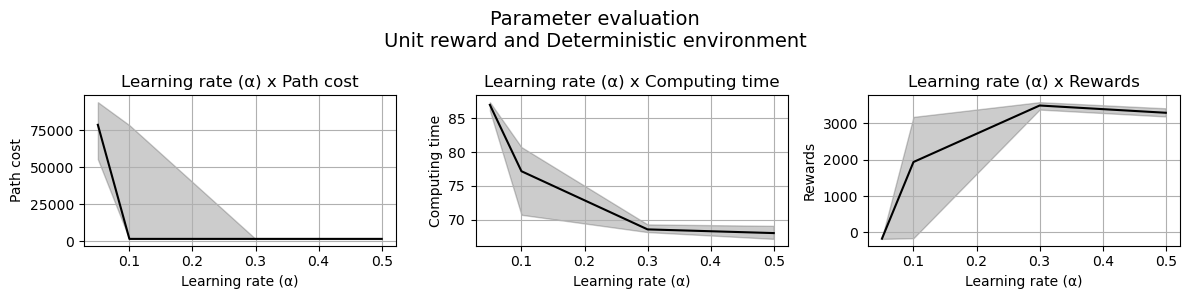

In [38]:
analysis_results3("unit", "deterministic")

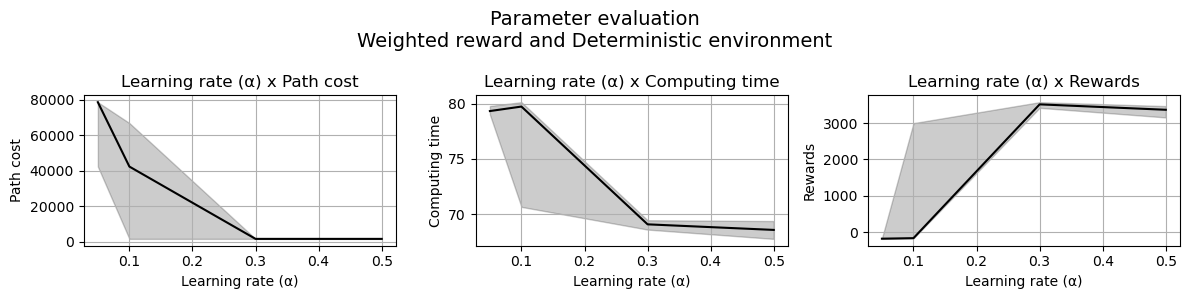

In [39]:
analysis_results3("weighted", "deterministic")

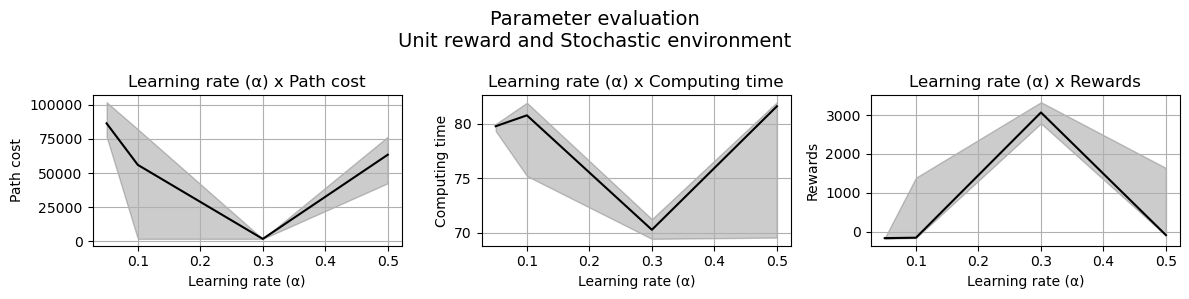

In [40]:
analysis_results3("unit", "stochastic")

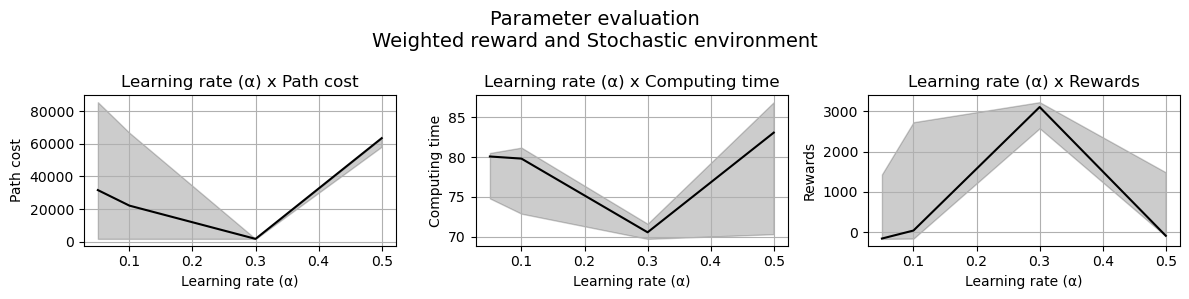

In [41]:
analysis_results3("weighted", "stochastic")